# ClimateQ&A
---
Goal of the notebook: Recommended graphs functionality

Inputs of the notebook:

Output of the notebook:


Takeaways:

Questions, thoughts and remarks:
- What do I put for query instruction ?
  - Default is "Represent this sentence for searching relevant passages:"
  - embedding_function = get_embeddings_function(query_instruction="")

## Dependencies and path
Adjust the argument in `sys.path.append` to align with your specific requirements.

In [1]:
import pandas as pd 
import numpy as np
import os
from IPython.display import display, Markdown

%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/home/dora/climate-question-answering")

from dotenv import load_dotenv
load_dotenv()

True

## 1. Import objects
### 1.1 LLM

In [2]:
from climateqa.engine.llm import get_llm
llm = get_llm(provider="openai")

### 1.2 Embedding

In [3]:
from climateqa.engine.embeddings import get_embeddings_function

embeddings_function = get_embeddings_function()

Loading embeddings model:  BAAI/bge-base-en-v1.5


/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### 1.3 Reranker

In [4]:
from climateqa.engine.reranker import get_reranker

reranker = get_reranker("nano")
reranker

Loading FlashRankRanker model ms-marco-TinyBERT-L-2-v2
Loading model FlashRank model ms-marco-TinyBERT-L-2-v2...


### 1.4 IPCC vectorstore

In [5]:
from climateqa.engine.vectorstore import get_pinecone_vectorstore

vectorstore = get_pinecone_vectorstore(embeddings_function)

/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `Pinecone` was deprecated in LangChain 0.0.18 and will be removed in 0.3.0. An updated version of the class exists in the langchain-pinecone package and should be used instead. To use it run `pip install -U langchain-pinecone` and import as `from langchain_pinecone import Pinecone`.
  warn_deprecated(


## 2 Vectorstore

### 2.1 IEA data

In [46]:
from langchain_community.document_loaders import DataFrameLoader
from langchain_chroma import Chroma

df_iea = pd.read_csv("/home/dora/climate-question-answering/data/charts_iea.csv")
df_iea = df_iea.rename(columns={'url': 'returned_content'})
df_iea["doc_id"] = "iea_" + df_iea.index.astype(str)
df_iea["source"] = "IEA"
df_iea.head()

,title,returned_content,sources,notes,appears_in,appears_in_url,doc_id,source
0,Capital requirements for mining to meet demand...,https://www.iea.org/data-and-statistics/charts...,IEA analysis based on data from S&P Global and...,Capital requirements are calculated based on c...,Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...,iea_0,IEA
1,"IEA energy transition mineral price index, Jan...",https://www.iea.org/data-and-statistics/charts...,IEA analysis based on Bloomberg and S&P Global.,IEA energy transition minerals price index is ...,Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...,iea_1,IEA
2,Price developments of minerals and metals by c...,https://www.iea.org/data-and-statistics/charts...,IEA analysis based on Bloomberg and S&P Global.,"Base metals include iron, aluminium, zinc and ...",Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...,iea_2,IEA
3,Capital expenditure on nonferrous metal produc...,https://www.iea.org/data-and-statistics/charts...,IEA analysis based on company annual reports a...,"For diversified majors, capex on the productio...",Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...,iea_3,IEA
4,"Selected environmental, social and governance ...",https://www.iea.org/data-and-statistics/charts...,IEA analysis based on the latest sustainabilit...,GHG= greenhouse gas. Aggregated data for 25 ma...,Global Critical Minerals Outlook 2024,https://www.iea.org/reports/global-critical-mi...,iea_4,IEA


In [47]:
# Load csv file of charts
loader_iea = DataFrameLoader(df_iea, page_content_column='title')
documents_iea = loader_iea.load()
len(documents_iea)

5355

### 2.2 OWID data

In [48]:
df_owid = pd.read_csv("/home/dora/climate-question-answering/data/charts_owid.csv")

# rename column 'embedding' to 'returned_content'
df_owid = df_owid.rename(columns={'embedding': 'returned_content'})
df_owid.head()

df_owid["doc_id"] = "owid_" + df_owid.index.astype(str)
df_owid["source"] = "OWID"
df_owid.head()

,category,title,url,returned_content,subtitle,doc_id,source
0,Access to Energy,Number of people with and without access to cl...,https://ourworldindata.org/grapher/number-with...,"<iframe src=""https://ourworldindata.org/graphe...",Clean cooking fuels and technologies represent...,owid_0,OWID
1,Access to Energy,Number of people without access to clean fuels...,https://ourworldindata.org/grapher/number-with...,"<iframe src=""https://ourworldindata.org/graphe...",Clean cooking fuels and technologies represent...,owid_1,OWID
2,Access to Energy,"People without clean fuels for cooking, by wor...",https://ourworldindata.org/grapher/people-with...,"<iframe src=""https://ourworldindata.org/graphe...",Data source: World Bank,owid_2,OWID
3,Access to Energy,Share of the population without access to clea...,https://ourworldindata.org/grapher/share-of-th...,"<iframe src=""https://ourworldindata.org/graphe...",Access to clean fuels or technologies such as ...,owid_3,OWID
4,Access to Energy,Share with access to electricity vs. per capit...,https://ourworldindata.org/grapher/share-with-...,"<iframe src=""https://ourworldindata.org/graphe...",Having access to electricity is defined in int...,owid_4,OWID


In [9]:
df_owid.category.unique()

array(['Access to Energy', 'Agricultural Production',
       'Agricultural Regulation & Policy', 'Air Pollution',
       'Animal Welfare', 'Antibiotics', 'Biodiversity', 'Biofuels',
       'Biological & Chemical Weapons', 'CO2 & Greenhouse Gas Emissions',
       'COVID-19', 'Clean Water', 'Clean Water & Sanitation',
       'Climate Change', 'Crop Yields', 'Diet Compositions',
       'Electricity', 'Electricity Mix', 'Energy', 'Energy Efficiency',
       'Energy Prices', 'Environmental Impacts of Food Production',
       'Environmental Protection & Regulation', 'Famines', 'Farm Size',
       'Fertilizers', 'Fish & Overfishing', 'Food Supply', 'Food Trade',
       'Food Waste', 'Food and Agriculture', 'Forests & Deforestation',
       'Fossil Fuels', 'Future Population Growth',
       'Hunger & Undernourishment', 'Indoor Air Pollution', 'Land Use',
       'Land Use & Yields in Agriculture', 'Lead Pollution',
       'Meat & Dairy Production', 'Metals & Minerals',
       'Natural Disasters

In [54]:
loader_owid = DataFrameLoader(df_owid, page_content_column='title')
documents_owid = loader_owid.load()
len(documents_owid)

2202

### 2.3 Merged Data Loader

In [51]:
from langchain_community.document_loaders.merge import MergedDataLoader

loader_all = MergedDataLoader(loaders=[loader_iea, loader_owid])
documents_all = loader_all.load()
len(documents_all)

7557

In [52]:
documents_all[-1]

Document(page_content='Wildfire area burned by land cover type', metadata={'category': 'Wildfires', 'url': 'https://ourworldindata.org/grapher/annual-burned-area-by-landcover', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/annual-burned-area-by-landcover?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'subtitle': 'Total area of forests, savannas, shrublands/grasslands, croplands, and other land that have been burned as a result of wildfires each year.', 'doc_id': 'owid_2201', 'source': 'OWID'})

### 2.4 Chroma vectorstore

In [56]:
# DO NOT RUN AGAIN (persisted)
# vectorstore_graphs = Chroma.from_documents(documents_all, embeddings_function, persist_directory="/home/dora/climate-question-answering/data/vectorstore")
vectorstore_graphs = Chroma.from_documents(documents_owid, embeddings_function, persist_directory="/home/dora/climate-question-answering/data/vectorstore_owid")

INFO:chromadb.telemetry.posthog:Anonymized telemetry enabled. See https://docs.trychroma.com/telemetry for more information.


In [61]:
from langchain_chroma import Chroma

vectorstore_graphs = Chroma(persist_directory="/home/dora/climate-question-answering/data/vectorstore_owid", embedding_function=embeddings_function)

INFO:chromadb.telemetry.posthog:Anonymized telemetry enabled. See https://docs.trychroma.com/telemetry for more information.


In [65]:
vectorstore_graphs.similarity_search_with_relevance_scores("What is the trend of clean water?")

[(Document(page_content='Share of water bodies with good ambient water quality', metadata={'category': 'Clean Water & Sanitation', 'doc_id': 'owid_742', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/water-bodies-good-water-quality?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Water quality is assessed by means of core physical and chemical parameters that reflect natural water quality. A water body is classified as "good" quality if at least 80% of monitoring values meet target quality levels.', 'url': 'https://ourworldindata.org/grapher/water-bodies-good-water-quality'}),
  0.46955342022080526),
 (Document(page_content='Share of water bodies with good ambient water quality', metadata={'category': 'Water Use & Stress', 'doc_id': 'owid_2184', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/water-bodies-good-water-quality?tab=map" loadi

## 3. Retriever for recommended graphs

### 3.1 Custom retriever

In [44]:
from langchain_core.retrievers import BaseRetriever
from langchain_core.documents.base import Document
from langchain_core.vectorstores import VectorStore
from langchain_core.callbacks.manager import CallbackManagerForRetrieverRun

from typing import List

class GraphRetriever(BaseRetriever):
    vectorstore:VectorStore
    sources:list = ["IEA", "OWID"] # plus tard ajouter OurWorldInData # faudra integrate avec l'autre retriever
    threshold:float = 0.5
    k_total:int = 10

    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:

        # Check if all elements in the list are IEA or OWID
        assert isinstance(self.sources,list)
        assert any([x in ["IEA", "OWID"] for x in self.sources])

        # Prepare base search kwargs
        filters = {}

        filters["source"] = {"$in": self.sources}

        docs = self.vectorstore.similarity_search_with_score(query=query, filter=filters, k=self.k_total)
        
        # Filter if scores are below threshold
        docs = [x for x in docs if x[1] > self.threshold]

        # Add score to metadata
        results = []
        for i,(doc,score) in enumerate(docs):
            doc.metadata["similarity_score"] = score
            doc.metadata["content"] = doc.page_content
            results.append(doc)

        return results

In [78]:
retriever = GraphRetriever(vectorstore=vectorstore_graphs)

In [79]:
retriever.invoke("hydrogen import evolutions")

[Document(page_content='Energy imports and exports', metadata={'category': 'Energy', 'doc_id': 'owid_969', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/energy-imports-and-exports-energy-use?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Energy trade, measured as the percentage of energy use. Positive values indicate a country or region is a net importer of energy. Negative numbers indicate a country or region is a net exporter.', 'url': 'https://ourworldindata.org/grapher/energy-imports-and-exports-energy-use', 'similarity_score': 0.7722015976905823, 'content': 'Energy imports and exports'}),
 Document(page_content='Import of environmentally sound technologies', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_400', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/import-of-environmentally-sound-technologies?tab=

### 3.2 Retriever node

In [86]:
import sys
import os
from contextlib import contextmanager

from climateqa.engine.reranker import rerank_docs



def divide_into_parts(target, parts):
    # Base value for each part
    base = target // parts
    # Remainder to distribute
    remainder = target % parts
    # List to hold the result
    result = []
    
    for i in range(parts):
        if i < remainder:
            # These parts get base value + 1
            result.append(base + 1)
        else:
            # The rest get the base value
            result.append(base)
    
    return result


@contextmanager
def suppress_output():
    # Open a null device
    with open(os.devnull, 'w') as devnull:
        # Store the original stdout and stderr
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        # Redirect stdout and stderr to the null device
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            # Restore stdout and stderr
            sys.stdout = old_stdout
            sys.stderr = old_stderr


def make_graph_retriever_node(vectorstore, reranker, rerank_by_question=True, k_final=15, k_before_reranking=100):

        def retrieve_graphs(state):
            print("---- Retrieving graphs ----")
            
            POSSIBLE_SOURCES = ["IEA", "OWID"]
            questions = state["questions"]
            sources_input = state["sources_input"]

            auto_mode = "auto" in sources_input

            # There are several options to get the final top k
            # Option 1 - Get 100 documents by question and rerank by question
            # Option 2 - Get 100/n documents by question and rerank the total
            if rerank_by_question:
                k_by_question = divide_into_parts(k_final,len(questions))
            
            docs = []
            
            for i,q in enumerate(questions):
                
                question = q["question"]
                
                print(f"Subquestion {i}: {question}")
                
                # If auto mode, we use all sources
                if auto_mode:
                    sources = POSSIBLE_SOURCES
                # Otherwise, we use the config
                else:
                    sources = sources_input

                if any([x in POSSIBLE_SOURCES for x in sources]):

                    sources = [x for x in sources if x in POSSIBLE_SOURCES]
                    
                    # Search the document store using the retriever
                    retriever = GraphRetriever(
                        vectorstore = vectorstore,
                        sources = sources,
                        k_total = k_before_reranking,
                        threshold = 0.5,
                        )
                    docs_question = retriever.get_relevant_documents(question)
                    
                    # Rerank
                    if reranker is not None:
                        with suppress_output():
                            docs_question = rerank_docs(reranker,docs_question,question)
                    else:
                        # Add a default reranking score
                        for doc in docs_question:
                            doc.metadata["reranking_score"] = doc.metadata["similarity_score"]
                        
                    # If rerank by question we select the top documents for each question
                    if rerank_by_question:
                        docs_question = docs_question[:k_by_question[i]]
                        
                    # Add sources used in the metadata
                    for doc in docs_question:
                        doc.metadata["sources_used"] = sources
                    
                    print(f"{len(docs_question)} graphs retrieved for subquestion {i + 1}: {docs_question}")
                    
                    # Add to the list of docs
                    docs.extend(docs_question)

                else:
                    print(f"There are no graphs which match the sources filtered on. Sources filtered on: {sources}. Sources available: {POSSIBLE_SOURCES}.")
                    
                # Sorting the list in descending order by rerank_score
                # Then select the top k
                docs = sorted(docs, key=lambda x: x.metadata["reranking_score"], reverse=True)
                docs = docs[:k_final]

            return {"recommended_content": docs}
        
        return retrieve_graphs

In [87]:
# import sys
# import os
# from contextlib import contextmanager

# from climateqa.engine.reranker import rerank_docs


# def divide_into_parts(target, parts):
#     # Base value for each part
#     base = target // parts
#     # Remainder to distribute
#     remainder = target % parts
#     # List to hold the result
#     result = []
    
#     for i in range(parts):
#         if i < remainder:
#             # These parts get base value + 1
#             result.append(base + 1)
#         else:
#             # The rest get the base value
#             result.append(base)
    
#     return result


# @contextmanager
# def suppress_output():
#     # Open a null device
#     with open(os.devnull, 'w') as devnull:
#         # Store the original stdout and stderr
#         old_stdout = sys.stdout
#         old_stderr = sys.stderr
#         # Redirect stdout and stderr to the null device
#         sys.stdout = devnull
#         sys.stderr = devnull
#         try:
#             yield
#         finally:
#             # Restore stdout and stderr
#             sys.stdout = old_stdout
#             sys.stderr = old_stderr



# def make_retriever_node(vectorstore, reranker, rerank_by_question=True, k_final=15, k_before_reranking=100):

#     def retrieve_documents(state):
        
#         POSSIBLE_SOURCES = ["IEA","OWID"]
#         questions = state["questions"]
#         sources_input = state["sources_input"]
        
#         # Sert à rien pour l'instant puisqu'on a des valeurs par défaut et qu'on fait pas de query transformation sur les sources de graphs
#         # Use sources from the user input or from the LLM detection
#         if "sources_input" not in state or state["sources_input"] is None:
#             sources_input = ["auto"]
#         else:
#             sources_input = state["sources_input"]
#         auto_mode = "auto" in sources_input

#         # There are several options to get the final top k
#         # Option 1 - Get 100 documents by question and rerank by question
#         # Option 2 - Get 100/n documents by question and rerank the total
#         if rerank_by_question:
#             k_by_question = divide_into_parts(k_final,len(questions))
        
#         docs = []
        
#         for i,q in enumerate(questions):
            
#             sources = q["sources"]
#             question = q["question"]
            
#             # If auto mode, we use the sources detected by the LLM
#             if auto_mode:
#                 sources = [x for x in sources if x in POSSIBLE_SOURCES]
                
#             # Otherwise, we use the config
#             else:
#                 sources = sources_input
                
#             # Search the document store using the retriever
#             # Configure high top k for further reranking step
#             retriever = GraphRetriever(
#                 vectorstore=vectorstore,
#                 sources = sources,
#                 k_total = k_before_reranking,
#                 threshold = 0.5,
#                 )
#             docs_question = retriever.get_relevant_documents(question)
            
#             # Rerank
#             if reranker is not None:
#                 with suppress_output():
#                     docs_question = rerank_docs(reranker,docs_question,question)
#             else:
#                 # Add a default reranking score
#                 for doc in docs_question:
#                     # doc.metadata["reranking_score"] = doc.metadata["similarity_score"]
#                     doc.metadata["reranking_score"] = "No reranking"
                
#             # If rerank by question we select the top documents for each question
#             if rerank_by_question:
#                 docs_question = docs_question[:k_by_question[i]]
                
#             # Add sources used in the metadata
#             for doc in docs_question:
#                 doc.metadata["sources_used"] = sources
            
#             # Add to the list of docs
#             docs.extend(docs_question)
            
#         # Sorting the list in descending order by rerank_score
#         # Then select the top k
#         docs = sorted(docs, key=lambda x: x.metadata["reranking_score"], reverse=True)
#         docs = docs[:k_final]
        
#         new_state = {"documents": docs}
#         return new_state
    
#     return retrieve_documents

## 4. Node functions

In [182]:
from operator import itemgetter

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts.prompt import PromptTemplate
from langchain_core.prompts.base import format_document

DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(template="""Title: {page_content}. \n\n Embedding link: {returned_content}""")

def _combine_recommended_content(
    docs, document_prompt=DEFAULT_DOCUMENT_PROMPT, sep="\n\n-----------------\n\n"
):

    doc_strings =  []

    for i,doc in enumerate(docs):
        # chunk_type = "Doc" if doc.metadata["chunk_type"] == "text" else "Image"
        chunk_type = "Graph"
        if isinstance(doc,str):
            doc_formatted = doc
        else:
            doc_formatted = format_document(doc, document_prompt)

        doc_string = f"{chunk_type} {i+1}: \n\n" + doc_formatted
        # doc_string = doc_string.replace("\n"," ") 
        doc_strings.append(doc_string)

    return sep.join(doc_strings)

In [183]:
display(Markdown(_combine_recommended_content(output["recommended_content"])))

Graph 1: 

Title: Hydrogen use in the Sustainable Development Scenario, 2019-2050. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/hydrogen-use-in-the-sustainable-development-scenario-2019-2050

-----------------

Graph 2: 

Title: Global hydrogen demand by sector in the Sustainable Development Scenario, 2019-2070. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/global-hydrogen-demand-by-sector-in-the-sustainable-development-scenario-2019-2070

-----------------

Graph 3: 

Title: Role of north-western Europe in the European hydrogen landscape, 2020. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/role-of-north-western-europe-in-the-european-hydrogen-landscape-2020

-----------------

Graph 4: 

Title: Reduction in global hydrogen demand by sector in the Reduced Innovation Case, relative to the Sustainable Development Scenario, 2030-2040. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/reduction-in-global-hydrogen-demand-by-sector-in-the-reduced-innovation-case-relative-to-the-sustainable-development-scenario-2030-2040

-----------------

Graph 5: 

Title: Global power sector demand for hydrogen and hydrogen-based fuels in the Net Zero Scenario. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/global-power-sector-demand-for-hydrogen-and-hydrogen-based-fuels-in-the-net-zero-scenario

-----------------

Graph 6: 

Title: Energy imports and exports. 

 Embedding link: <iframe src="https://ourworldindata.org/grapher/energy-imports-and-exports-energy-use?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>

-----------------

Graph 7: 

Title: Hydrogen demand in industry, 2020. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/hydrogen-demand-in-industry-2020

-----------------

Graph 8: 

Title: Low-emissions hydrogen imports into Northwest Europe by status, based on announced projects, 2030-2040. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/low-emissions-hydrogen-imports-into-northwest-europe-by-status-based-on-announced-projects-2030-2040

-----------------

Graph 9: 

Title: Top five countries by total energy supply by energy source, 2018. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/top-five-countries-by-total-energy-supply-by-energy-source-2018

-----------------

Graph 10: 

Title: Global demand for pure hydrogen, 1975-2018. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/global-demand-for-pure-hydrogen-1975-2018

-----------------

Graph 11: 

Title: Top five countries by total energy supply by energy source, 2019. 

 Embedding link: https://www.iea.org/data-and-statistics/charts/top-five-countries-by-total-energy-supply-by-energy-source-2019

In [16]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

from climateqa.engine.chains.prompts import answer_prompt_graph_template

class RecommendedGraph(BaseModel):
    title: str = Field(description="Title of the graph")
    embedding: str = Field(description="Embedding link of the graph")

# class RecommendedGraphs(BaseModel):
#     recommended_content: List[RecommendedGraph] = Field(description="List of recommended graphs")

def make_rag_graph_chain(llm):
    parser = JsonOutputParser(pydantic_object=RecommendedGraph)
    prompt = PromptTemplate(
        template=answer_prompt_graph_template,
        input_variables=["query", "recommended_content"],
        partial_variables={"format_instructions": parser.get_format_instructions()},
    )

    chain = prompt | llm | parser
    return chain

def make_rag_graph_node(llm):
    chain = make_rag_graph_chain(llm)

    def answer_rag_graph(state):
        output = chain.invoke(state)
        return {"graph_returned": output}

    return answer_rag_graph

## 5. Graph

### 5.1 Make graph agent

In [11]:
import sys
import os
from contextlib import contextmanager

from langchain.schema import Document
from langgraph.graph import END, StateGraph
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod

from typing_extensions import TypedDict
from typing import List, Dict

from IPython.display import display, HTML, Image

from climateqa.engine.chains.answer_chitchat import make_chitchat_node
from climateqa.engine.chains.answer_ai_impact import make_ai_impact_node
from climateqa.engine.chains.query_transformation import make_query_transform_node
from climateqa.engine.chains.translation import make_translation_node
from climateqa.engine.chains.intent_categorization import make_intent_categorization_node
from climateqa.engine.chains.retriever import make_retriever_node
from climateqa.engine.chains.answer_rag import make_rag_node
from climateqa.engine.chains.set_defaults import set_defaults
from climateqa.engine.chains.graph_retriever import make_graph_retriever_node


class GraphState(TypedDict):
    """
    Represents the state of our graph.
    """
    user_input : str
    language : str
    intent : str
    query: str
    questions : List[dict]
    answer: str
    audience: str
    sources_input: List[str]
    documents: List[Document]
    recommended_content : List[Document]
    graph_returned: Dict[str,str]

def search(state):
    return {}

def route_intent(state):
    intent = state["intent"]
    if intent in ["chitchat","esg"]:
        return "answer_chitchat"
    elif intent == "ai_impact":
        return "answer_ai_impact"
    else:
        # Search route
        return "search"
    
def route_translation(state):
    if state["language"].lower() == "english":
        return "transform_query"
    else:
        return "translate_query"
    
def route_based_on_relevant_docs(state,threshold_docs=0.2):
    docs = [x for x in state["documents"] if x.metadata["reranking_score"] > threshold_docs]
    if len(docs) > 0:
        return "answer_rag"
    else:
        return "answer_rag_no_docs"
    

def make_id_dict(values):
    return {k:k for k in values}

def make_graph_agent(llm, vectorstore_ipcc, vectorstore_graphs, reranker, threshold_docs=0.2):
    
    workflow = StateGraph(GraphState)

    # Define the node functions
    categorize_intent = make_intent_categorization_node(llm)
    transform_query = make_query_transform_node(llm)
    translate_query = make_translation_node(llm)
    answer_chitchat = make_chitchat_node(llm)
    answer_ai_impact = make_ai_impact_node(llm)
    retrieve_documents = make_retriever_node(vectorstore_ipcc, reranker)
    retrieve_graphs = make_graph_retriever_node(vectorstore_graphs, reranker)
    answer_rag_graph = make_rag_graph_node(llm)
    answer_rag = make_rag_node(llm, with_docs=True)
    answer_rag_no_docs = make_rag_node(llm, with_docs=False)

    # Define the nodes
    workflow.add_node("set_defaults", set_defaults)
    workflow.add_node("categorize_intent", categorize_intent)
    workflow.add_node("search", search)
    workflow.add_node("transform_query", transform_query)
    workflow.add_node("translate_query", translate_query)
    workflow.add_node("answer_chitchat", answer_chitchat)
    workflow.add_node("answer_ai_impact", answer_ai_impact)
    workflow.add_node("retrieve_graphs", retrieve_graphs)
    workflow.add_node("answer_rag_graph", answer_rag_graph)
    workflow.add_node("retrieve_documents", retrieve_documents)
    workflow.add_node("answer_rag", answer_rag)
    workflow.add_node("answer_rag_no_docs", answer_rag_no_docs)

    # Entry point
    workflow.set_entry_point("set_defaults")

    # CONDITIONAL EDGES
    workflow.add_conditional_edges(
        "categorize_intent",
        route_intent,
        make_id_dict(["answer_chitchat","answer_ai_impact","search"])
    )

    workflow.add_conditional_edges(
        "search",
        route_translation,
        make_id_dict(["translate_query","transform_query"])
    )

    workflow.add_conditional_edges(
        "retrieve_documents",
        lambda x : route_based_on_relevant_docs(x,threshold_docs=threshold_docs),
        make_id_dict(["answer_rag","answer_rag_no_docs"])
    )

    # Define the edges
    workflow.add_edge("set_defaults", "categorize_intent")
    workflow.add_edge("translate_query", "transform_query")
    workflow.add_edge("transform_query", "retrieve_graphs")
    workflow.add_edge("retrieve_graphs", "answer_rag_graph")
    workflow.add_edge("answer_rag_graph", "retrieve_documents")
    workflow.add_edge("answer_rag", END)
    workflow.add_edge("answer_rag_no_docs", END)
    workflow.add_edge("answer_chitchat", END)
    workflow.add_edge("answer_ai_impact", END)

    # Compile
    app = workflow.compile()
    return app




def display_graph(app):

    display(
        Image(
            app.get_graph(xray = True).draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )

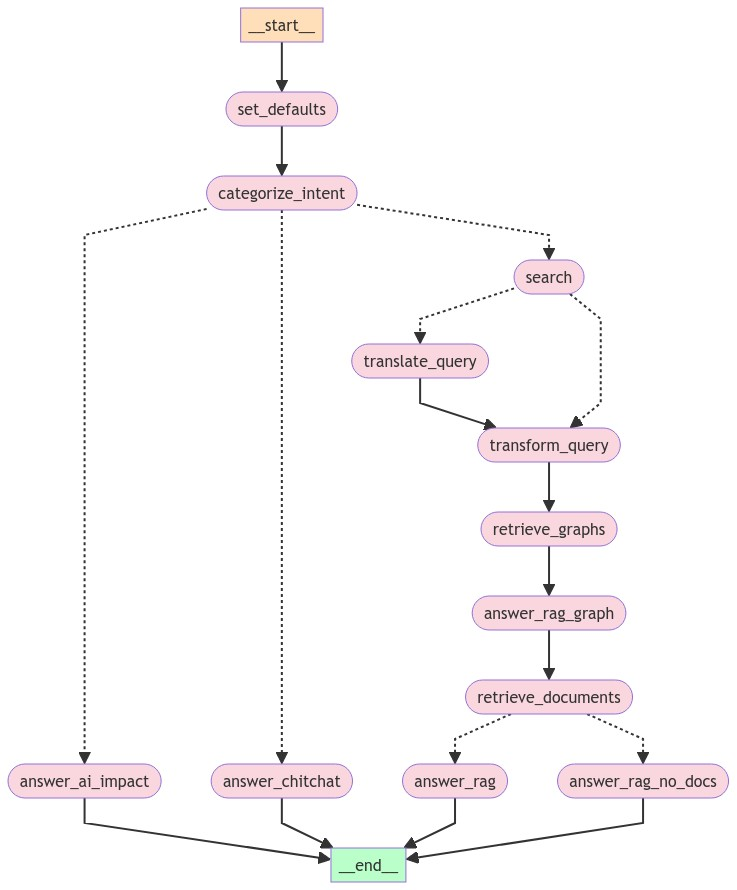

In [12]:
app = make_graph_agent(llm=llm, vectorstore_ipcc=vectorstore, vectorstore_graphs=vectorstore_graphs, reranker=reranker)
display_graph(app)

### 5.2 Testing graph agent

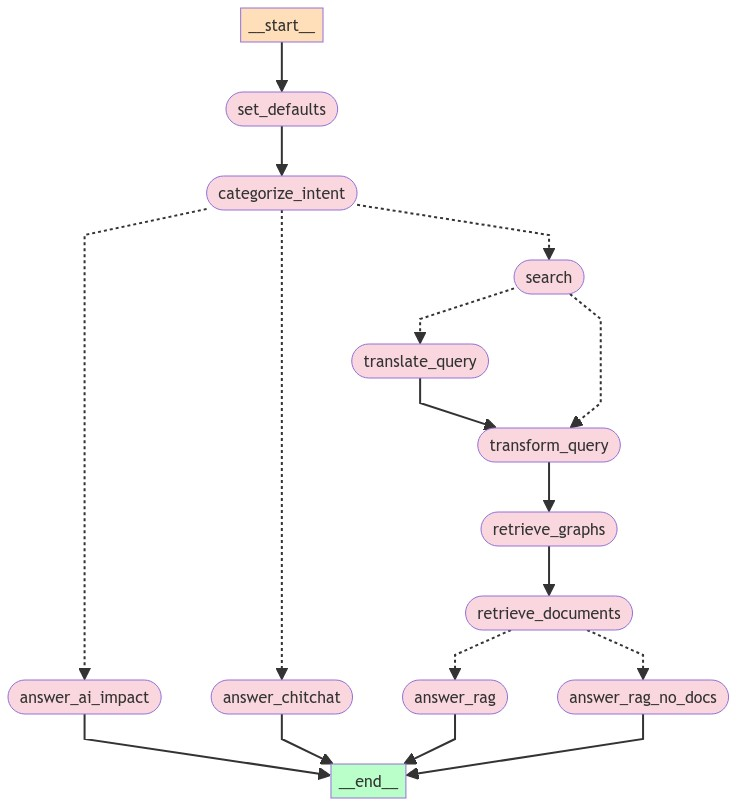

In [86]:
from climateqa.engine.graph import make_graph_agent, display_graph

app = make_graph_agent(llm=llm, vectorstore_ipcc=vectorstore, vectorstore_graphs=vectorstore_graphs, reranker=reranker)
display_graph(app)

In [87]:
output = await app.ainvoke({"user_input": "J'habite à paris et je veux aller à marseille, d'un point de vue climatique est-ce que c'est mieux de prendre le train ou l'avion ?"})
output

---- Setting defaults ----


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


---- Retrieving graphs ----
Subquestion 0: What are the environmental impacts of taking a train from Paris to Marseille?
8 graphs retrieved for subquestion 1: [Document(page_content='CO2 emissions from transport', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_333', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/co2-emissions-transport?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Emissions are measured in tonnes. Domestic aviation and shipping emissions are included at the national level. International aviation and shipping emissions are included only at the global level.', 'url': 'https://ourworldindata.org/grapher/co2-emissions-transport', 'similarity_score': 0.842741847038269, 'content': 'CO2 emissions from transport', 'reranking_score': 3.826981992460787e-05, 'query_used_for_retrieval': 'What are the environmental impacts of t

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Answer:
Je n'ai pas trouvé de passages spécifiques dans les rapports du GIEC ou de l'IPBES pour répondre à votre question. Cela peut être dû aux limites de la recherche textuelle. Cependant, il est important de noter que le transport aérien a un impact plus important sur le climat en termes d'émissions de gaz à effet de serre par passager par kilomètre parcouru par rapport au transport ferroviaire.

Le train est généralement considéré comme une option plus respectueuse de l'environnement que l'avion en raison de ses émissions de CO2 plus faibles. Donc, d'un point de vue climatique, il serait préférable de prendre le train pour voyager de Paris à Marseille. Cela contribuerait à réduire votre empreinte carbone personnelle.

Si vous avez d'autres questions plus spécifiques sur les impacts climatiques des différents modes de transport, n'hésitez pas à reformuler votre question pour que je puisse mieux vous aider en me basant sur les rapports du GIEC et de l'IPBES.


{'user_input': "J'habite à paris et je veux aller à marseille, d'un point de vue climatique est-ce que c'est mieux de prendre le train ou l'avion ?",
 'language': 'French',
 'intent': 'search',
 'query': 'I live in Paris and I want to go to Marseille, from a climatic point of view, is it better to take the train or the plane?',
 'questions': [{'question': 'What are the environmental impacts of taking a train from Paris to Marseille?',
   'sources': ['IPCC']},
  {'question': 'What are the environmental impacts of taking a plane from Paris to Marseille?',
   'sources': ['IPCC']}],
 'answer': "Je n'ai pas trouvé de passages spécifiques dans les rapports du GIEC ou de l'IPBES pour répondre à votre question. Cela peut être dû aux limites de la recherche textuelle. Cependant, il est important de noter que le transport aérien a un impact plus important sur le climat en termes d'émissions de gaz à effet de serre par passager par kilomètre parcouru par rapport au transport ferroviaire.\n\nLe tr

In [80]:
output["recommended_content"]

[Document(page_content='CO2 emissions from transport', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_333', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/co2-emissions-transport?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Emissions are measured in tonnes. Domestic aviation and shipping emissions are included at the national level. International aviation and shipping emissions are included only at the global level.', 'url': 'https://ourworldindata.org/grapher/co2-emissions-transport', 'similarity_score': 0.842741847038269, 'content': 'CO2 emissions from transport', 'reranking_score': 3.900628871633671e-05, 'query_used_for_retrieval': 'What are the environmental impacts of taking a train from Paris to Marseille?', 'sources_used': ['IEA', 'OWID']}),
 Document(page_content='CO2 emissions from transport', metadata={'category': 'Trans

In [37]:
async for event in app.astream_events({"user_input": "J'habite à paris et je veux aller à marseille, d'un point de vue climatique est-ce que c'est mieux de prendre le train ou l'avion ?"}, version = "v1"):
    # if event["name"] == "retrieve_documents" and event["event"] == "on_chain_end":
        # print(event)
    print(event)

{'event': 'on_chain_start', 'run_id': '0699efce-24db-41ca-9f07-4f98c23b9d8e', 'name': 'LangGraph', 'tags': [], 'metadata': {}, 'data': {'input': {'user_input': "J'habite à paris et je veux aller à marseille, d'un point de vue climatique est-ce que c'est mieux de prendre le train ou l'avion ?"}}}
{'event': 'on_chain_start', 'name': '__start__', 'run_id': '0ab2876b-b4cb-4fb5-a9b6-fdd4168e471b', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__'}, 'data': {'input': {'user_input': "J'habite à paris et je veux aller à marseille, d'un point de vue climatique est-ce que c'est mieux de prendre le train ou l'avion ?"}}}
{'event': 'on_chain_end', 'name': '__start__', 'run_id': '0ab2876b-b4cb-4fb5-a9b6-fdd4168e471b', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__'}, 'data': {'input': {'user_input': "J'habite à paris et je veux aller à marseille, d'un point de vue climatique est

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '42de7095-4c62-42d2-890c-e7bd48a34235', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_intent', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'IntentCategorizer'}}, id='run-42de7095-4c62-42d2-890c-e7bd48a34235')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '42de7095-4c62-42d2-890c-e7bd48a34235', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_intent', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-42de7095-4c62-42d2-890c-e7bd48a34235')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '42de7095-4c62-42d2-890c-e7bd48a34235', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_inten

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '4adb8afa-0b64-4538-b80c-7f8ba81cccf7', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'translate_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'Translation'}}, id='run-4adb8afa-0b64-4538-b80c-7f8ba81cccf7')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '4adb8afa-0b64-4538-b80c-7f8ba81cccf7', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'translate_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-4adb8afa-0b64-4538-b80c-7f8ba81cccf7')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '4adb8afa-0b64-4538-b80c-7f8ba81cccf7', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 4, 'langgraph_node': 'translate_query', 'ls_mode

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'bf807c54-7455-4228-a486-46385a3fd2d1', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 5, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryDecomposition'}}, id='run-bf807c54-7455-4228-a486-46385a3fd2d1')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'bf807c54-7455-4228-a486-46385a3fd2d1', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 5, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-bf807c54-7455-4228-a486-46385a3fd2d1')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'bf807c54-7455-4228-a486-46385a3fd2d1', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 5, 'langgraph_node': 'transform_query', '

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'e2c567d3-1049-49ba-8bcb-5352b629fe4f', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 5, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryAnalysis'}}, id='run-e2c567d3-1049-49ba-8bcb-5352b629fe4f')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'e2c567d3-1049-49ba-8bcb-5352b629fe4f', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 5, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-e2c567d3-1049-49ba-8bcb-5352b629fe4f')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'e2c567d3-1049-49ba-8bcb-5352b629fe4f', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 5, 'langgraph_node': 'transform_query', 'ls_mo

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '1a3041c6-9254-4310-9196-3c9d27581ae1', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 5, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'QueryAnalysis'}}, id='run-1a3041c6-9254-4310-9196-3c9d27581ae1')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '1a3041c6-9254-4310-9196-3c9d27581ae1', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 5, 'langgraph_node': 'transform_query', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-1a3041c6-9254-4310-9196-3c9d27581ae1')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '1a3041c6-9254-4310-9196-3c9d27581ae1', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 5, 'langgraph_node': 'transform_query', 'ls_mo

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '25de5b46-4a44-4997-9c90-7826683e9beb', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 7, 'langgraph_node': 'answer_rag_graph', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', id='run-25de5b46-4a44-4997-9c90-7826683e9beb')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '25de5b46-4a44-4997-9c90-7826683e9beb', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 7, 'langgraph_node': 'answer_rag_graph', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='{\n', id='run-25de5b46-4a44-4997-9c90-7826683e9beb')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '25de5b46-4a44-4997-9c90-7826683e9beb', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 7, 'langgraph_node': 'answer_rag_graph', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content=' ', id='run-25de5b46-4a44-4997-9c90-7826683e9beb')}}
{'event': 'on_chat_model_strea

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '01851b6f-2209-4977-8021-1652d835309d', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 9, 'langgraph_node': 'answer_rag_no_docs', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', id='run-01851b6f-2209-4977-8021-1652d835309d')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '01851b6f-2209-4977-8021-1652d835309d', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 9, 'langgraph_node': 'answer_rag_no_docs', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='Je', id='run-01851b6f-2209-4977-8021-1652d835309d')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '01851b6f-2209-4977-8021-1652d835309d', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 9, 'langgraph_node': 'answer_rag_no_docs', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content=' n', id='run-01851b6f-2209-4977-8021-1652d835309d')}}
{'event': 'on_chat_model

In [13]:
inputs = {'user_input': 'impact of ai?', 'audience': 'expert and climate scientists that are not afraid of technical terms', 'sources': ['IPCC']}
result = app.astream_events(inputs,version = "v1")

/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: This API is in beta and may change in the future.
  warn_beta(


In [35]:
async for event in result:
    print(event)

{'event': 'on_chain_start', 'run_id': 'da753bb9-2339-4fc0-b1d7-86443019c4df', 'name': 'LangGraph', 'tags': [], 'metadata': {}, 'data': {'input': {'user_input': 'impact of ai?', 'audience': 'expert and climate scientists that are not afraid of technical terms', 'sources': ['IPCC']}}}
{'event': 'on_chain_start', 'name': '__start__', 'run_id': '07d726da-2d7c-48a3-ad2b-5c28e29729a9', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__'}, 'data': {'input': {'user_input': 'impact of ai?', 'audience': 'expert and climate scientists that are not afraid of technical terms', 'sources': ['IPCC']}}}
{'event': 'on_chain_end', 'name': '__start__', 'run_id': '07d726da-2d7c-48a3-ad2b-5c28e29729a9', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {'langgraph_step': 0, 'langgraph_node': '__start__'}, 'data': {'input': {'user_input': 'impact of ai?', 'audience': 'expert and climate scientists that are not afraid of technical terms', 'sour

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '2d9ccf59-3d78-42b1-8458-83a9c3479ef8', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_intent', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '', 'name': 'IntentCategorizer'}}, id='run-2d9ccf59-3d78-42b1-8458-83a9c3479ef8')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '2d9ccf59-3d78-42b1-8458-83a9c3479ef8', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_intent', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', additional_kwargs={'function_call': {'arguments': '{"', 'name': ''}}, id='run-2d9ccf59-3d78-42b1-8458-83a9c3479ef8')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': '2d9ccf59-3d78-42b1-8458-83a9c3479ef8', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 2, 'langgraph_node': 'categorize_inten

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'db848c5f-43af-45e1-8b97-345044f399d6', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 3, 'langgraph_node': 'answer_ai_impact', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='', id='run-db848c5f-43af-45e1-8b97-345044f399d6')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'db848c5f-43af-45e1-8b97-345044f399d6', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 3, 'langgraph_node': 'answer_ai_impact', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content='The', id='run-db848c5f-43af-45e1-8b97-345044f399d6')}}
{'event': 'on_chat_model_stream', 'name': 'ChatOpenAI', 'run_id': 'db848c5f-43af-45e1-8b97-345044f399d6', 'tags': ['seq:step:2'], 'metadata': {'langgraph_step': 3, 'langgraph_node': 'answer_ai_impact', 'ls_model_type': 'chat'}, 'data': {'chunk': AIMessageChunk(content=' environmental', id='run-db848c5f-43af-45e1-8b97-345044f399d6')}}
{'event': 'on_cha

: 

## 6. Gradio

In [31]:
from front.utils import make_html_source,parse_output_llm_with_sources,serialize_docs,make_toolbox
query = inputs["user_input"]
steps_display = {
"categorize_intent":("🔄️ Analyzing user message",True),
"transform_query":("🔄️ Thinking step by step to answer the question",True),
"retrieve_documents":("🔄️ Searching in the knowledge base",False),
}
history = [(query,None)]
start_streaming = False
intent = None


async for event in result:

    if event["event"] == "on_chat_model_stream" and event["metadata"]["langgraph_node"] in ["answer_rag", "answer_chitchat", "answer_ai_impact"]:
        if start_streaming == False:
            start_streaming = True
            history[-1] = (query,"")

        new_token = event["data"]["chunk"].content
        # time.sleep(0.01)
        previous_answer = history[-1][1]
        previous_answer = previous_answer if previous_answer is not None else ""
        answer_yet = previous_answer + new_token
        answer_yet = parse_output_llm_with_sources(answer_yet)
        history[-1] = (query,answer_yet)

    
    elif event["name"] == "retrieve_documents" and event["event"] == "on_chain_end":
        try:
            docs = event["data"]["output"]["documents"]
            docs_html = []
            for i, d in enumerate(docs, 1):
                docs_html.append(make_html_source(d, i))
            docs_html = "".join(docs_html)
        except Exception as e:
            print(f"Error getting documents: {e}")
            print(event)

    # elif event["name"] == "retrieve_documents" and event["event"] == "on_chain_start":
    #     print(event)
    #     questions = event["data"]["input"]["questions"]
    #     questions = "\n".join([f"{i+1}. {q['question']} ({q['source']})" for i,q in enumerate(questions)])
    #     answer_yet = "🔄️ Searching in the knowledge base\n{questions}"
    #     history[-1] = (query,answer_yet)

    elif event["name"] == "retrieve_graphs" and event["event"] == "on_chain_end":
        try:
            graphs = event["data"]["output"]["recommended_content"]
        except Exception as e:
            print(f"Error getting graphs: {e}")
            print(event)


    for event_name,(event_description,display_output) in steps_display.items():
        if event["name"] == event_name:
            if event["event"] == "on_chain_start":
                # answer_yet = f"<p><span class='loader'></span>{event_description}</p>"
                # answer_yet = make_toolbox(event_description, "", checked = False)
                answer_yet = event_description
                history[-1] = (query,answer_yet)
            # elif event["event"] == "on_chain_end":
            #     answer_yet = ""
            #     history[-1] = (query,answer_yet)
                # if display_output:
                #     print(event["data"]["output"])

    # if op['path'] == path_reformulation: # reforulated question
    #     try:
    #         output_language = op['value']["language"] # str
    #         output_query = op["value"]["question"]
    #     except Exception as e:
    #         raise gr.Error(f"ClimateQ&A Error: {e} - The error has been noted, try another question and if the error remains, you can contact us :)")
    
    # if op["path"] == path_keywords:
    #     try:
    #         output_keywords = op['value']["keywords"] # str
    #         output_keywords = " AND ".join(output_keywords)
    #     except Exception as e:
    #         pass



    history = [tuple(x) for x in history]
    # yield history,docs_html,output_query,output_language,gallery,output_query,output_keywords

In [16]:
from langchain_core.documents import Document

graphs = [Document(page_content='Global warming contributions by gas and source', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_383', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/global-warming-by-gas-and-source?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'The global mean surface temperature change as a result of the cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.', 'url': 'https://ourworldindata.org/grapher/global-warming-by-gas-and-source', 'similarity_score': 0.5550143122673035, 'content': 'Global warming contributions by gas and source', 'reranking_score': 0.651607871055603, 'query_used_for_retrieval': 'How do human activities contribute to global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Global warming contributions by gas and source', metadata={'category': 'Climate Change', 'doc_id': 'owid_764', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/global-warming-by-gas-and-source?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'The global mean surface temperature change as a result of the cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.', 'url': 'https://ourworldindata.org/grapher/global-warming-by-gas-and-source', 'similarity_score': 0.5550143122673035, 'content': 'Global warming contributions by gas and source', 'reranking_score': 0.651607871055603, 'query_used_for_retrieval': 'How do human activities contribute to global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Global warming contributions from fossil fuels and land use', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_384', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/warming-fossil-fuels-land-use?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "The global mean surface temperature change as a result of a country or region's cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.", 'url': 'https://ourworldindata.org/grapher/warming-fossil-fuels-land-use', 'similarity_score': 0.6049439907073975, 'content': 'Global warming contributions from fossil fuels and land use', 'reranking_score': 0.22002366185188293, 'query_used_for_retrieval': 'How do human activities contribute to global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Global warming contributions from fossil fuels and land use', metadata={'category': 'Climate Change', 'doc_id': 'owid_765', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/warming-fossil-fuels-land-use?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "The global mean surface temperature change as a result of a country or region's cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.", 'url': 'https://ourworldindata.org/grapher/warming-fossil-fuels-land-use', 'similarity_score': 0.6049439907073975, 'content': 'Global warming contributions from fossil fuels and land use', 'reranking_score': 0.22002366185188293, 'query_used_for_retrieval': 'How do human activities contribute to global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Main sources of methane emissions', metadata={'appears_in': 'Global Methane Tracker 2024', 'appears_in_url': 'https://www.iea.org/reports/global-methane-tracker-2024', 'doc_id': 'iea_133', 'returned_content': 'https://www.iea.org/data-and-statistics/charts/main-sources-of-methane-emissions', 'source': 'IEA', 'sources': 'Methane emissions and abatement potential for oil, gas, and coal are based on the IEA (2023) Global Methane Tracker (https://www.iea.org/data-and-statistics/data-tools/methane-tracker-data-explorer) ; agriculture and waste is based on UNEP (2023), Global Methane Assessment (https://www.unep.org/resources/report/global-methane-assessment-benefits-and-costs-mitigating-methane-emissions). Emissions from biomass and bioenergy burning, which total around 10 Mt (https://essd.copernicus.org/articles/12/1561/2020/) of methane per year each, are not shown.', 'similarity_score': 0.6158384084701538, 'content': 'Main sources of methane emissions', 'reranking_score': 0.0806397795677185, 'query_used_for_retrieval': 'What are the main causes of global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Global warming: Contributions to the change in global mean surface temperature', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_386', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/contributions-global-temp-change?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "This is shown as a country or region's share of the global mean surface temperature change as a result of its cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.", 'url': 'https://ourworldindata.org/grapher/contributions-global-temp-change', 'similarity_score': 0.6807445883750916, 'content': 'Global warming: Contributions to the change in global mean surface temperature', 'reranking_score': 0.03409431874752045, 'query_used_for_retrieval': 'How do human activities contribute to global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Global warming: Contributions to the change in global mean surface temperature', metadata={'category': 'Climate Change', 'doc_id': 'owid_766', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/contributions-global-temp-change?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "This is shown as a country or region's share of the global mean surface temperature change as a result of its cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.", 'url': 'https://ourworldindata.org/grapher/contributions-global-temp-change', 'similarity_score': 0.6807445883750916, 'content': 'Global warming: Contributions to the change in global mean surface temperature', 'reranking_score': 0.03409431874752045, 'query_used_for_retrieval': 'How do human activities contribute to global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Carbon dioxide emissions factors', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_342', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/carbon-dioxide-emissions-factor?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Emissions factors quantify the average CO₂ output per unit of energy. They are measured in kilograms of CO₂ per megawatt-hour (MWh) of energy from various fossil fuel sources.', 'url': 'https://ourworldindata.org/grapher/carbon-dioxide-emissions-factor', 'similarity_score': 0.6963810324668884, 'content': 'Carbon dioxide emissions factors', 'reranking_score': 0.007733839564025402, 'query_used_for_retrieval': 'What are the main causes of global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Carbon dioxide emissions factors', metadata={'category': 'Fossil Fuels', 'doc_id': 'owid_1408', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/carbon-dioxide-emissions-factor?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Emissions factors quantify the average CO₂ output per unit of energy. They are measured in kilograms of CO₂ per megawatt-hour (MWh) of energy from various fossil fuel sources.', 'url': 'https://ourworldindata.org/grapher/carbon-dioxide-emissions-factor', 'similarity_score': 0.6963810324668884, 'content': 'Carbon dioxide emissions factors', 'reranking_score': 0.007733839564025402, 'query_used_for_retrieval': 'What are the main causes of global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Contribution to global mean surface temperature rise from agriculture and land use', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_359', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/global-warming-land?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': "The global mean surface temperature change as a result of a country or region's cumulative emissions of carbon dioxide, methane, and nitrous oxide. This is for land use and agriculture only.", 'url': 'https://ourworldindata.org/grapher/global-warming-land', 'similarity_score': 0.7010847330093384, 'content': 'Contribution to global mean surface temperature rise from agriculture and land use', 'reranking_score': 0.006090907845646143, 'query_used_for_retrieval': 'How do human activities contribute to global warming?', 'sources_used': ['IEA', 'OWID']}), Document(page_content='Greenhouse gas emissions', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_387', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/total-ghg-emissions?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'Greenhouse gas emissions include carbon dioxide, methane and nitrous oxide from all sources, including land-use change. They are measured in tonnes of carbon dioxide-equivalents over a 100-year timescale.', 'url': 'https://ourworldindata.org/grapher/total-ghg-emissions', 'similarity_score': 0.711588978767395, 'content': 'Greenhouse gas emissions', 'reranking_score': 0.001999091589823365, 'query_used_for_retrieval': 'What are the main causes of global warming?', 'sources_used': ['IEA', 'OWID']})]
graphs

[Document(page_content='Global warming contributions by gas and source', metadata={'category': 'CO2 & Greenhouse Gas Emissions', 'doc_id': 'owid_383', 'returned_content': '<iframe src="https://ourworldindata.org/grapher/global-warming-by-gas-and-source?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>', 'source': 'OWID', 'subtitle': 'The global mean surface temperature change as a result of the cumulative emissions of three gases – carbon dioxide, methane, and nitrous oxide.', 'url': 'https://ourworldindata.org/grapher/global-warming-by-gas-and-source', 'similarity_score': 0.5550143122673035, 'content': 'Global warming contributions by gas and source', 'reranking_score': 0.651607871055603, 'query_used_for_retrieval': 'How do human activities contribute to global warming?', 'sources_used': ['IEA', 'OWID']}),
 Document(page_content='Global warming contributions by gas and source', metadata={'category': 'Climate Chan

In [17]:
graphs = [
            {
                "embedding": x.metadata["returned_content"],
                "metadata": {
                    "source": x.metadata["source"],
                    "category": x.metadata["category"]
                    }
                } for x in graphs if x.metadata["source"] == "OWID"
            ]

graphs

[{'embedding': '<iframe src="https://ourworldindata.org/grapher/global-warming-by-gas-and-source?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>',
  'metadata': {'source': 'OWID',
   'category': 'CO2 & Greenhouse Gas Emissions'}},
 {'embedding': '<iframe src="https://ourworldindata.org/grapher/global-warming-by-gas-and-source?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>',
  'metadata': {'source': 'OWID', 'category': 'Climate Change'}},
 {'embedding': '<iframe src="https://ourworldindata.org/grapher/warming-fossil-fuels-land-use?tab=map" loading="lazy" style="width: 100%; height: 600px; border: 0px none;" allow="web-share; clipboard-write"></iframe>',
  'metadata': {'source': 'OWID',
   'category': 'CO2 & Greenhouse Gas Emissions'}},
 {'embedding': '<iframe src="https://ourworldindata.org/grapher/warming-fossil-fuels-land-use?tab=map" l

In [20]:
from collections import defaultdict

def generate_html(graphs):
    # Organize graphs by category
    categories = defaultdict(list)
    for graph in graphs:
        category = graph['metadata']['category']
        categories[category].append(graph['embedding'])

    # Begin constructing the HTML
    html_code = '''
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Graphs by Category</title>
    <style>
        .tab-content {
            display: none;
        }
        .tab-content.active {
            display: block;
        }
        .tabs {
            margin-bottom: 20px;
        }
        .tab-button {
            background-color: #ddd;
            border: none;
            padding: 10px 20px;
            cursor: pointer;
            margin-right: 5px;
        }
        .tab-button.active {
            background-color: #ccc;
        }
    </style>
    <script>
        function showTab(tabId) {
            var contents = document.getElementsByClassName('tab-content');
            var buttons = document.getElementsByClassName('tab-button');
            for (var i = 0; i < contents.length; i++) {
                contents[i].classList.remove('active');
                buttons[i].classList.remove('active');
            }
            document.getElementById(tabId).classList.add('active');
            document.querySelector('button[data-tab="'+tabId+'"]').classList.add('active');
        }
    </script>
</head>
<body>
    <div class="tabs">
'''

    # Add buttons for each category
    for i, category in enumerate(categories.keys()):
        active_class = 'active' if i == 0 else ''
        html_code += f'<button class="tab-button {active_class}" onclick="showTab(\'tab-{i}\')" data-tab="tab-{i}">{category}</button>'

    html_code += '</div>'

    # Add content for each category
    for i, (category, embeds) in enumerate(categories.items()):
        active_class = 'active' if i == 0 else ''
        html_code += f'<div id="tab-{i}" class="tab-content {active_class}">'
        for embed in embeds:
            html_code += embed
        html_code += '</div>'

    html_code += '''
</body>
</html>
'''

    return html_code


In [22]:
generate_graphs_html(graphs)

'\n    <style>\n      /* Style the tab */\n      .tab {\n        overflow: hidden;\n        border: 1px solid #ccc;\n        background-color: #f1f1f1;\n      }\n\n      /* Style the buttons inside the tab */\n      .tab button {\n        background-color: inherit;\n        float: left;\n        border: none;\n        outline: none;\n        cursor: pointer;\n        padding: 14px 16px;\n        transition: 0.3s;\n        font-size: 17px;\n      }\n\n      /* Change background color of buttons on hover */\n      .tab button:hover {\n        background-color: #ddd;\n      }\n\n      /* Create an active/current tablink class */\n      .tab button.active {\n        background-color: #ccc;\n      }\n\n      /* Style the tab content */\n      .tabcontent {\n        display: none;\n        padding: 6px 12px;\n        border-top: none;\n      }\n\n      /* Show the tab content when it\'s active */\n      .tabcontent.active {\n        display: block;\n      }\n    </style>\n    \n    <div clas

In [18]:
embeddings_function = get_embeddings_function()
llm = get_llm(provider="openai",max_tokens = 1024,temperature = 0.0)
reranker = get_reranker("nano")

# Create vectorstore and retriever
vectorstore = get_pinecone_vectorstore(embeddings_function)
vectorstore_graphs = Chroma(persist_directory="/home/dora/climate-question-answering/data/vectorstore", embedding_function=embeddings_function)

# agent = make_graph_agent(llm,vectorstore,reranker)
agent = make_graph_agent(llm=llm, vectorstore_ipcc=vectorstore, vectorstore_graphs=vectorstore_graphs, reranker=reranker)

async def chat(query,history,audience,sources,reports):
    """taking a query and a message history, use a pipeline (reformulation, retriever, answering) to yield a tuple of:
    (messages in gradio format, messages in langchain format, source documents)"""

    date_now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f">> NEW QUESTION ({date_now}) : {query}")

    if audience == "Children":
        audience_prompt = audience_prompts["children"]
    elif audience == "General public":
        audience_prompt = audience_prompts["general"]
    elif audience == "Experts":
        audience_prompt = audience_prompts["experts"]
    else:
        audience_prompt = audience_prompts["experts"]

    # Prepare default values
    if len(sources) == 0:
        sources = ["IPCC"]

    if len(reports) == 0:
        reports = []
    
    inputs = {"user_input": query,"audience": audience_prompt,"sources":sources}
    print(f"\n\nInputs:\n {inputs}\n\n")
    result = agent.astream_events(inputs,version = "v1") #{"callbacks":[MyCustomAsyncHandler()]})
    # result = rag_chain.stream(inputs)

    # path_reformulation = "/logs/reformulation/final_output"
    # path_keywords = "/logs/keywords/final_output"
    # path_retriever = "/logs/find_documents/final_output"
    # path_answer = "/logs/answer/streamed_output_str/-"

    docs = []
    graphs_html = ""
    docs_html = ""
    output_query = ""
    output_language = ""
    output_keywords = ""
    gallery = []
    updates = {}
    start_streaming = False

    steps_display = {
        "categorize_intent":("🔄️ Analyzing user message",True),
        "transform_query":("🔄️ Thinking step by step to answer the question",True),
        "retrieve_documents":("🔄️ Searching in the knowledge base",False),
    }

    try:
        async for event in result:

            if event["event"] == "on_chat_model_stream" and event["metadata"]["langgraph_node"] in ["answer_rag", "answer_chitchat", "answer_ai_impact"]:
                if start_streaming == False:
                    start_streaming = True
                    history[-1] = (query,"")

                new_token = event["data"]["chunk"].content
                # time.sleep(0.01)
                previous_answer = history[-1][1]
                previous_answer = previous_answer if previous_answer is not None else ""
                answer_yet = previous_answer + new_token
                answer_yet = parse_output_llm_with_sources(answer_yet)
                history[-1] = (query,answer_yet)
            
            elif event["name"] == "retrieve_documents" and event["event"] == "on_chain_end":
                try:
                    docs = event["data"]["output"]["documents"]
                    docs_html = []
                    for i, d in enumerate(docs, 1):
                        docs_html.append(make_html_source(d, i))
                    docs_html = "".join(docs_html)

                    print(docs_html)
                except Exception as e:
                    print(f"Error getting documents: {e}")
                    print(event)

            # elif event["name"] == "retrieve_documents" and event["event"] == "on_chain_start":
            #     print(event)
            #     questions = event["data"]["input"]["questions"]
            #     questions = "\n".join([f"{i+1}. {q['question']} ({q['source']})" for i,q in enumerate(questions)])
            #     answer_yet = "🔄️ Searching in the knowledge base\n{questions}"
            #     history[-1] = (query,answer_yet)

            elif event["name"] == "retrieve_graphs" and event["event"] == "on_chain_end":
                try:
                    recommended_content = event["data"]["output"]["recommended_content"]
                    graphs = [
                        {
                            "embedding": x.metadata["returned_content"],
                            "metadata": {
                                "source": x.metadata["source"],
                                "category": x.metadata["category"]
                                }
                                } for x in recommended_content if x.metadata["source"] == "OWID"
                                ]
                    
                    graphs_by_category = defaultdict(list)
    
                    # Organize graphs by category
                    for graph in graphs:
                        category = graph['metadata']['category']
                        graphs_by_category[category].append(graph['embedding'])        

                    
                    for category, graphs in graphs_by_category.items():
                        embeddings = "\n".join(graphs)
                        updates[graph_displays[category]] = embeddings
                    
                    print(f"\n\nUpdates:\n {updates}\n\n")
                                                
                except Exception as e:
                    print(f"Error getting graphs: {e}")

            for event_name,(event_description,display_output) in steps_display.items():
                if event["name"] == event_name:
                    if event["event"] == "on_chain_start":
                        # answer_yet = f"<p><span class='loader'></span>{event_description}</p>"
                        # answer_yet = make_toolbox(event_description, "", checked = False)
                        answer_yet = event_description
                        history[-1] = (query,answer_yet)
                    # elif event["event"] == "on_chain_end":
                    #     answer_yet = ""
                    #     history[-1] = (query,answer_yet)
                        # if display_output:
                        #     print(event["data"]["output"])

            # if op['path'] == path_reformulation: # reforulated question
            #     try:
            #         output_language = op['value']["language"] # str
            #         output_query = op["value"]["question"]
            #     except Exception as e:
            #         raise gr.Error(f"ClimateQ&A Error: {e} - The error has been noted, try another question and if the error remains, you can contact us :)")
            
            # if op["path"] == path_keywords:
            #     try:
            #         output_keywords = op['value']["keywords"] # str
            #         output_keywords = " AND ".join(output_keywords)
            #     except Exception as e:
            #         pass



            history = [tuple(x) for x in history]
            yield history,docs_html,output_query,output_language,gallery,updates#,output_query,output_keywords


    except Exception as e:
        raise gr.Error(f"{e}")


    try:
        # Log answer on Azure Blob Storage
        if os.getenv("GRADIO_ENV") != "local":
            timestamp = str(datetime.now().timestamp())
            file = timestamp + ".json"
            prompt = history[-1][0]
            logs = {
                "user_id": str(user_id),
                "prompt": prompt,
                "query": prompt,
                "question":output_query,
                "sources":sources,
                "docs":serialize_docs(docs),
                "answer": history[-1][1],
                "time": timestamp,
            }
            log_on_azure(file, logs, share_client)
    except Exception as e:
        print(f"Error logging on Azure Blob Storage: {e}")
        raise gr.Error(f"ClimateQ&A Error: {str(e)[:100]} - The error has been noted, try another question and if the error remains, you can contact us :)")

    image_dict = {}
    for i,doc in enumerate(docs):
        
        if doc.metadata["chunk_type"] == "image":
            try:
                key = f"Image {i+1}"
                image_path = doc.metadata["image_path"].split("documents/")[1]
                img = get_image_from_azure_blob_storage(image_path)

                # Convert the image to a byte buffer
                buffered = BytesIO()
                img.save(buffered, format="PNG")
                img_str = base64.b64encode(buffered.getvalue()).decode()

                # Embedding the base64 string in Markdown
                markdown_image = f"![Alt text](data:image/png;base64,{img_str})"
                image_dict[key] = {"img":img,"md":markdown_image,"caption":doc.page_content,"key":key,"figure_code":doc.metadata["figure_code"]}
            except Exception as e:
                print(f"Skipped adding image {i} because of {e}")

    if len(image_dict) > 0:

        gallery = [x["img"] for x in list(image_dict.values())]
        img = list(image_dict.values())[0]
        img_md = img["md"]
        img_caption = img["caption"]
        img_code = img["figure_code"]
        if img_code != "N/A":
            img_name = f"{img['key']} - {img['figure_code']}"
        else:
            img_name = f"{img['key']}"

        answer_yet = history[-1][1] + f"\n\n{img_md}\n<p class='chatbot-caption'><b>{img_name}</b> - {img_caption}</p>"
        history[-1] = (history[-1][0],answer_yet)
        history = [tuple(x) for x in history]

        print(f"\n\nImages:\n{gallery}")

    # gallery = [x.metadata["image_path"] for x in docs if (len(x.metadata["image_path"]) > 0 and "IAS" in x.metadata["image_path"])]
    # if len(gallery) > 0:
    #     gallery = list(set("|".join(gallery).split("|")))
    #     gallery = [get_image_from_azure_blob_storage(x) for x in gallery]

        yield history,docs_html,output_query,output_language,gallery,updates#,output_query,output_keywords


INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cpu
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5


Loading embeddings model:  BAAI/bge-base-en-v1.5


/home/dora/anaconda3/envs/climateqa_huggingface/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading FlashRankRanker model ms-marco-TinyBERT-L-2-v2
Loading model FlashRank model ms-marco-TinyBERT-L-2-v2...


INFO:chromadb.telemetry.posthog:Anonymized telemetry enabled. See https://docs.trychroma.com/telemetry for more information.


NameError: name 'make_graph_agent' is not defined